# 환경 설정

In [1]:
!pip install numpy==1.22.1

In [2]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch>=1.8.1

!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
  Using cached gluonnlp-0.8.0.tar.gz (235 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292696 sha256=8b29a996a79e3bc51708262e4d5cba36e6423a150f555ca65a6eedc5a03f5d40
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-9fp18k4a/kobert-tokenizer_19a486d054f14e32b3075ee2d35fd0ba
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-9fp18k4a/kobert-tokenizer_19a486d054f14e32b3075ee2d35fd0ba
  Resolved https://github.com/SK

In [3]:
import gluonnlp as nlp

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


# 데이터 준비

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 경로 설정
path = '/content/drive/MyDrive/'

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [8]:
# Torch GPU 설정
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)

In [9]:
data = pd.read_csv('/content/drive/MyDrive/annotation_1.xlsx - Sheet1.csv')

In [10]:
data.head()

,id,NO1,Column
0,1,0,내담자: 안녕하세요 상담선생님. 저는 오랫동안 힘든 시간을 보냈습니다.
1,1,0,내담자: 초등학교 때 왕따를 심하게 당해 중도에 학교를 그만뒀어요. 그 후 정신과 ...
2,1,0,내담자: 직장생활도 그렇게 오래 유지하지 못했어요. 몇 개월씩만 다녔죠. 그리고 이...
3,1,0,내담자: 요즘에는 버스에서도 옆자리에 아무도 앉지 않더라고요. 청소년 문화인가 싶어...
4,1,0,내담자: 늦은 나이에 직장도 없이 '조현병' 진단까지 받았습니다. 이성에 대한 호기...


In [42]:
folder_path = '/content/drive/MyDrive/NLP/annotation/240522버전_중복제거 및 병합 완료'
file_name = 'finals+corrected_duplicated_id_cleansing_2.csv'

data = pd.read_csv(folder_path+'/'+file_name)

In [43]:
data.head()

,id,sort,NO1,Column,내담자,상담자,token_len
0,1.0,1,0.0,안녕하세요. 상담사입니다. 무엇이 불편하시나요?,NaN,1.0,17
1,1.0,2,0.0,내가 약간 중2병 같은 걸 증상을 보이고 있어요.,1.0,NaN,14
2,1.0,3,0.0,"중2병 증상이라니, 어떤 증상이신 건가요?",NaN,1.0,17
3,1.0,4,0.0,"그러니까 공부하기 싫어하고, 공격적이고, 좀 무례하게 말하고 싶은 게 많아져서 그런...",1.0,NaN,26
4,1.0,5,0.0,그런 증상이 있으니까 힘드시겠죠. 중2병 같은 것이라고 생각하시는 이유는 무엇인가요?,NaN,1.0,28


In [68]:
#data['class'] = [1 if s >=3 else 0 for s in data['rating']] # 긍정이면 1, 부정이면 0
data.drop_duplicates(subset = ['Column'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
data['Column'] = data['Column'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
data['Column'] = data['Column'].str.replace('^ +', "") # 공백은 empty 값으로 변경
data['Column'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
data = data.dropna(how='any') # Null 값 제거

In [44]:
data['NO1'][data.NO1 == 2] = 1

<ipython-input-44-9b02a7944164>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NO1'][data.NO1 == 2] = 1


In [54]:
data['NO1'].unique()

array([ 0., nan,  1.])

In [61]:
data = data[data['NO1'].isin([0, 1])]

In [62]:
data = data[['id', 'NO1', 'Column']]

In [63]:
data_list = []
# Assuming 'data' is your DataFrame
for q, label in zip(data['Column'], data['NO1']):
    entry = []
    entry.append(q)
    entry.append(str(label))
    data_list.append(entry)

In [64]:
from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = 23)

In [65]:
print(dataset_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
print(dataset_test)

[['내담자: 제가 힘들어하는 게 남들보다 심각한 건 아닌 것 같아서, 괜히 귀찮게 할 순 없잖아요. 상담 받으러 가려면 또 아빠한테 혼날 것 같기도 하고... 그냥 이대로 있다가 언젠가 죽어버리면 편할 텐데. 계속 살아야 할 이유가 없는 것 같아요.', '1'], ['내담자: 맞아요. 세상에 점 하나 없어진다고 뭐가 달라지겠어요? 그걸 아니까 차라리 가려고 해요. 놓아야 할 걸 못 놓고 있어요. 제 인생에 뭐 하나 이룬 게 없는 것 같아요. 그래서 더 비참해요. 이 나이 먹도록 헛살았다는 생각밖에 안 들어요.', '1'], ['내담자: 안녕하세요 상담선생님. 저에게는 왜 힘들고 아픈 일들만 일어나는 것 같아요. 열심히 일해도 공사대금을 제때 받지 못하고, 가까운 사람을 도와주다가 오해를 받기도 했죠.', '0'], ['내담자: 정말 제가 무엇을 그렇게 잘못했나요? 세상은 저더러 포기하라는 것 같아요. 화가 나고 우울한 마음뿐입니다.', '0'], ['상담자: 아무리 가까운 사이라도 서로를 존중하며 상처 주는 말은 하면 안 됩니다. 남자친구의 그 말이 얼마나 큰 상처가 되었는지 짐작이 가네요. 하지만 그분의 실수로 자존감을 잃으셨다면 안타까운 일이에요.', '0'], ['내담자: 하지만 친구들도 우울증 있는 저 때문에 힘들어할 거예요. 상담사 선생님도 저 같은 환자 줄어들면 좋으시겠죠. 아무도 절 진심으로 걱정해주는 사람이 없는 것 같아요. 제가 세상에서 사라지는 게 모두를 위해 좋은 일인 것 같네요.', '1'], ['내담자: 고마워요. 오늘 상담을 하면서 죽음 말고 다른 선택지도 있다는 걸 깨달은 것 같아요. 아직도 많이 힘들고 막막하지만, 그래도 조금은 살아볼 용기가 생기네요. 혼자 모든 걸 해결하려 들기보다는 주변에 손을 내밀어 봐야겠어요. 쉽지 않은 길이 될 테지만 포기하지 않고 앞으로 나아가 볼게요. 제 삶에 작은 희망이 생길 수 있기를 바라면서요. 오늘 감사했습니다.', '0'], ['상담자: 지금 죽음까지 생각하실 정도로 많이 힘드시군요. 삶의 

In [66]:
print(len(dataset_train), len(dataset_test))

113008 28253


# 모델 불러오기

In [20]:
# BERTSentenceTransform 수정
class BERTSentenceTransform:
    """BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [83]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
                 # Ensure labels are numerical
        self.labels = [self.convert_label(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


    def convert_label(self, label):
        try:
            return np.int32(float(label))  # Convert to float first to handle '0.0' and then to int
        except ValueError:
            raise ValueError(f"Invalid label value: {label}")

In [22]:
# 하이퍼 파라미터 설정
max_len = 100
batch_size = 64
warmup_ratio = 0.1
num_epochs = 3
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [23]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [24]:
# kobert 공식 git에 있는 get_kobert_model 선언
def get_kobert_model(model_path, vocab_file, ctx="cpu"):
    bertmodel = BertModel.from_pretrained(model_path)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file,
                                                         padding_token='[PAD]')
    return bertmodel, vocab_b_obj

In [52]:
#import gluonnlp as nlp
from transformers import BertModel
bertmodel, vocab = get_kobert_model('skt/kobert-base-v1',tokenizer.vocab_file)
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

In [74]:
'''
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, tokenizer, max_len, pad, pair):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad = pad
        self.pair = pair

        # Ensure labels are numerical
        self.sentences = [self.transform([i[sent_idx]]) for i in dataset]
        self.labels = [self.convert_label(i[label_idx]) for i in dataset]

    def transform(self, sentence):
        # Tokenize the input sentence
        inputs = self.tokenizer.encode_plus(
            sentence[0],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length' if self.pad else 'do_not_pad',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return input_ids, attention_mask

    def convert_label(self, label):
        try:
            return np.int32(float(label))  # Convert to float first to handle '0.0' and then to int
        except ValueError:
            raise ValueError(f"Invalid label value: {label}")

    def __getitem__(self, idx):
        return (self.sentences[idx], self.labels[idx])

    def __len__(self):
        return len(self.labels)
'''

In [84]:
max_len = 64
data_train = BERTDataset(dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

In [85]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

:# TF-IDF top 500사용하여 임베딩 층 오버라이딩

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertModel, BertTokenizer, BertConfig

# Assuming 'data' is your DataFrame and it's already loaded
# Extract texts where NO1 == 1
texts = data[data.NO1 == 1]['Column'].values

# Step 1: Calculate TF-IDF scores and get top 500 words
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(texts)
top_500_words = vectorizer.get_feature_names_out()

In [29]:
# Step 2: Create a custom embedding layer using pre-trained Ko-BERT embeddings
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bert_model = BertModel.from_pretrained('skt/kobert-base-v1')

embedding_dim = 768  # Dimension of Ko-BERT embeddings
vocab_size = tokenizer.vocab_size
embedding_matrix = bert_model.embeddings.word_embeddings.weight.clone().detach()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [30]:
def get_word_embedding(word, tokenizer, bert_model):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Update embeddings for the top 500 words
vocab = tokenizer.get_vocab()
for word in top_500_words:
    if word in vocab:
        idx = vocab[word]
        embedding_matrix[idx] = torch.tensor(get_word_embedding(word, tokenizer, bert_model))

In [31]:
class CustomEmbedding(nn.Module):
    def __init__(self, embedding_matrix):
        super(CustomEmbedding, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)

    def forward(self, x):
        return self.embedding(x)

In [32]:
# Step 3: Replace Ko-BERT's embedding layer with the custom embedding layer
class CustomKoBERT(BertModel):
    def __init__(self, config, embedding_matrix):
        super(CustomKoBERT, self).__init__(config)
        self.embeddings.word_embeddings = nn.Embedding.from_pretrained(embedding_matrix)

# Create a BERT configuration
config = BertConfig.from_pretrained('skt/kobert-base-v1')

# Initialize the custom model with updated embeddings
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
custom_model = CustomKoBERT(config, embedding_matrix)

# Load pre-trained weights into the custom model
custom_model.load_state_dict(BertModel.from_pretrained("skt/kobert-base-v1").state_dict(), strict=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-32-0cc3d15c54cb>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


<All keys matched successfully>

In [77]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 2,   # 감정 클래스 수로 조정 긍정/부정 클래스2개
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)


In [78]:
model = BERTClassifier(bertmodel,  dr_rate = 0.5).to(device)

In [79]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

# 모델 학습

In [86]:
train_history = []
test_history = []
loss_history = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        # print(label.shape, out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    # train_history.append(train_acc / (batch_id+1))

    # .eval() : nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
    # 즉, model이 Dropout이나 BatNorm2d를 사용하는 경우, train 시에는 사용하지만 evaluation을 할 때에는 사용하지 않도록 설정해주는 함수
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))


  0%|          | 1/1766 [00:01<29:41,  1.01s/it]

epoch 1 batch id 1 loss 0.64048171043396 train acc 0.6875


 11%|█▏        | 201/1766 [02:08<16:36,  1.57it/s]

epoch 1 batch id 201 loss 0.08123598992824554 train acc 0.9515702736318408


 23%|██▎       | 401/1766 [04:17<14:39,  1.55it/s]

epoch 1 batch id 401 loss 0.03929859399795532 train acc 0.9716723815461347


 34%|███▍      | 601/1766 [06:26<12:28,  1.56it/s]

epoch 1 batch id 601 loss 0.0009120259201154113 train acc 0.978265391014975


 45%|████▌     | 801/1766 [08:35<10:19,  1.56it/s]

epoch 1 batch id 801 loss 0.003385289805009961 train acc 0.9820341760299626


 57%|█████▋    | 1001/1766 [10:44<08:15,  1.55it/s]

epoch 1 batch id 1001 loss 0.004247622564435005 train acc 0.9839847652347652


 68%|██████▊   | 1201/1766 [12:53<06:02,  1.56it/s]

epoch 1 batch id 1201 loss 0.005845332983881235 train acc 0.9857280391340549


 79%|███████▉  | 1401/1766 [15:01<03:55,  1.55it/s]

epoch 1 batch id 1401 loss 0.0002453492779750377 train acc 0.9868062990720914


 91%|█████████ | 1601/1766 [17:10<01:45,  1.56it/s]

epoch 1 batch id 1601 loss 0.0438506044447422 train acc 0.987673719550281


100%|██████████| 1766/1766 [18:57<00:00,  1.55it/s]


epoch 1 train acc 0.9883299122310306


100%|██████████| 442/442 [01:34<00:00,  4.67it/s]


epoch 1 test acc 0.9947327488687783


  0%|          | 1/1766 [00:00<28:58,  1.02it/s]

epoch 2 batch id 1 loss 0.0004561898240353912 train acc 1.0


 11%|█▏        | 201/1766 [02:10<16:45,  1.56it/s]

epoch 2 batch id 201 loss 0.015262413769960403 train acc 0.9931592039800995


 23%|██▎       | 401/1766 [04:19<14:41,  1.55it/s]

epoch 2 batch id 401 loss 0.03644871711730957 train acc 0.9934928304239401


 34%|███▍      | 601/1766 [06:27<12:31,  1.55it/s]

epoch 2 batch id 601 loss 0.0005382650997489691 train acc 0.993890391014975


 45%|████▌     | 801/1766 [08:36<10:19,  1.56it/s]

epoch 2 batch id 801 loss 0.00025096963508985937 train acc 0.9940699126092385


 57%|█████▋    | 1001/1766 [10:45<08:12,  1.55it/s]

epoch 2 batch id 1001 loss 0.0234265998005867 train acc 0.9939279470529471


 68%|██████▊   | 1201/1766 [12:54<06:03,  1.55it/s]

epoch 2 batch id 1201 loss 0.007903107441961765 train acc 0.9939503538717736


 79%|███████▉  | 1401/1766 [15:03<03:56,  1.55it/s]

epoch 2 batch id 1401 loss 0.0001892123109428212 train acc 0.9941671127765882


 91%|█████████ | 1601/1766 [17:12<01:45,  1.56it/s]

epoch 2 batch id 1601 loss 0.06221602112054825 train acc 0.9943882729544035


100%|██████████| 1766/1766 [18:58<00:00,  1.55it/s]


epoch 2 train acc 0.994532134767837


100%|██████████| 442/442 [01:34<00:00,  4.68it/s]


epoch 2 test acc 0.9953337104072398


  0%|          | 1/1766 [00:00<28:34,  1.03it/s]

epoch 3 batch id 1 loss 0.000482557195937261 train acc 1.0


 11%|█▏        | 201/1766 [02:09<16:45,  1.56it/s]

epoch 3 batch id 201 loss 0.008570867590606213 train acc 0.9947139303482587


 23%|██▎       | 401/1766 [04:18<14:36,  1.56it/s]

epoch 3 batch id 401 loss 0.05148664489388466 train acc 0.9952072942643392


 34%|███▍      | 601/1766 [06:26<12:30,  1.55it/s]

epoch 3 batch id 601 loss 0.0002579177962616086 train acc 0.9953982945091514


 45%|████▌     | 801/1766 [08:35<10:20,  1.55it/s]

epoch 3 batch id 801 loss 0.00021130220557097346 train acc 0.9956694756554307


 57%|█████▋    | 1001/1766 [10:44<08:12,  1.55it/s]

epoch 3 batch id 1001 loss 0.0003469347720965743 train acc 0.9957386363636364


 68%|██████▊   | 1201/1766 [12:52<06:03,  1.56it/s]

epoch 3 batch id 1201 loss 0.0039374446496367455 train acc 0.9957717527060783


 79%|███████▉  | 1401/1766 [15:01<03:54,  1.56it/s]

epoch 3 batch id 1401 loss 0.0001407040108460933 train acc 0.9958623304782298


 91%|█████████ | 1601/1766 [17:10<01:48,  1.52it/s]

epoch 3 batch id 1601 loss 0.005354574415832758 train acc 0.9960864303560275


100%|██████████| 1766/1766 [18:56<00:00,  1.55it/s]


epoch 3 train acc 0.9962397366930917


100%|██████████| 442/442 [01:33<00:00,  4.72it/s]

epoch 3 test acc 0.9950155542986425


#Fine tuning


In [87]:
#My Code
from transformers import BertModel
from kobert_tokenizer import KoBERTTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from transformers import AdamW, get_scheduler
from tqdm import tqdm

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 2,   # 감정 클래스 수로 조정 긍정/부정 클래스2개
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        logits = self.classifier(out)
        probabilities = F.softmax(logits, dim=-1)  # Apply softmax activation?
        return probabilities

# Assume bertmodel is defined and loaded appropriately
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

# Print the model architecture
print(model)

# 손실 함수 및 옵티마이저
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Learning rate scheduler
epochs = 3
#train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = 16, num_workers = 5)
num_training_steps = epochs * len(train_dataloader)
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),  # Warm-up for 10% of training steps
    num_training_steps=num_training_steps,
)

# 파인튜닝 루프
model.train()
for epoch in range(epochs):
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()
        scheduler.step()


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

100%|██████████| 7063/7063 [21:55<00:00,  5.37it/s]


In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

train_history = {
    'loss': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

test_history = {
    'loss': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'roc_auc': []
}

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    test_loss = 0.0

    model.train()
    all_train_labels = []
    all_train_preds = []
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        train_loss += loss.item()

        preds = out.argmax(dim=1).cpu().numpy()
        labels = label.cpu().numpy()
        all_train_preds.extend(preds)
        all_train_labels.extend(labels)

        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_precision = precision_score(all_train_labels, all_train_preds, average='macro')
    train_recall = recall_score(all_train_labels, all_train_preds, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_roc_auc = roc_auc_score(all_train_labels, all_train_preds, multi_class='ovo')

    train_history['loss'].append(train_loss)
    train_history['accuracy'].append(train_acc)
    train_history['precision'].append(train_precision)
    train_history['recall'].append(train_recall)
    train_history['f1'].append(train_f1)
    train_history['roc_auc'].append(train_roc_auc)

    model.eval()
    all_test_labels = []
    all_test_preds = []
    with torch.no_grad():
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length = valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)

            loss = loss_fn(out, label)
            test_loss += loss.item()
            test_acc += calc_accuracy(out, label)

            preds = out.argmax(dim=1).cpu().numpy()
            labels = label.cpu().numpy()
            all_test_preds.extend(preds)
            all_test_labels.extend(labels)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    test_precision = precision_score(all_test_labels, all_test_preds, average='macro')
    test_recall = recall_score(all_test_labels, all_test_preds, average='macro')
    test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
    test_roc_auc = roc_auc_score(all_test_labels, all_test_preds, multi_class='ovo')

    test_history['loss'].append(test_loss)
    test_history['accuracy'].append(test_acc)
    test_history['precision'].append(test_precision)
    test_history['recall'].append(test_recall)
    test_history['f1'].append(test_f1)
    test_history['roc_auc'].append(test_roc_auc)

    print(f"epoch {e+1} precision {test_precision} recall {test_recall} f1 {test_f1} roc_auc {test_roc_auc}")
    print()
    print("============================================================================================================================================")
    print()

NameError: name 'model' is not defined

 #Above code result

 0%|          | 1/206 [00:00<01:54,  1.79it/s]epoch 1 batch id 1 loss 0.43554213643074036 train acc 0.875
 98%|█████████▊| 201/206 [00:54<00:01,  3.62it/s]epoch 1 batch id 201 loss 0.31614646315574646 train acc 0.9636194029850746
100%|██████████| 206/206 [00:56<00:00,  3.67it/s]
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
epoch 1 precision 0.8346655992117256 recall 0.8230087969567285 f1 0.8286712334981627 roc_auc 0.8230087969567285

============================================================================================================================================

  0%|          | 0/206 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 1/206 [00:00<01:32,  2.23it/s]epoch 2 batch id 1 loss 0.43771982192993164 train acc 0.875
 98%|█████████▊| 201/206 [00:56<00:01,  3.61it/s]epoch 2 batch id 201 loss 0.31656813621520996 train acc 0.9614427860696517
100%|██████████| 206/206 [00:57<00:00,  3.58it/s]
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
epoch 2 precision 0.8346655992117256 recall 0.8230087969567285 f1 0.8286712334981627 roc_auc 0.8230087969567285

============================================================================================================================================

  0%|          | 0/206 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 1/206 [00:00<01:31,  2.23it/s]epoch 3 batch id 1 loss 0.4367964565753937 train acc 0.875
 98%|█████████▊| 201/206 [00:56<00:01,  3.62it/s]epoch 3 batch id 201 loss 0.31788885593414307 train acc 0.9623756218905473
100%|██████████| 206/206 [00:57<00:00,  3.59it/s]
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 13/13 [00:04<00:00,  2.86it/s]epoch 3 precision 0.8346655992117256 recall 0.8230087969567285 f1 0.8286712334981627 roc_auc 0.8230087969567285

============================================================================================================================================


In [ ]:
#Dataset
for epoch in range(3):
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        #out = model(token_ids, valid_length, segment_ids)
        # 데이터셋 구조확인
        #print("Input IDs:", train_dataloader['token_ids'], train_dataloader['token_ids'].shape)
        #print("Attention Mask:", train_batch['attention_mask'], train_batch['attention_mask'].shape)
        #print("Labels:", train_batch['labels'], train_batch['labels'].shape)
        #print("-"*15)

        # 모델 입력 및 출력 형태 확인
        print("token_ids shape:", token_ids.shape)
        print("valid_length shape:", valid_length.shape)
        print("segment_ids:", segment_ids.shape)

        # 출력 형태 확인
        #print("Output shape:", out.shape)
        #print("Target shape:", target_ids.shape)

  7%|▋         | 14/206 [00:00<00:04, 45.28it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 22%|██▏       | 46/206 [00:00<00:01, 104.51it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 37%|███▋      | 77/206 [00:00<00:00, 130.06it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 53%|█████▎    | 109/206 [00:01<00:00, 143.63it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 68%|██████▊   | 140/206 [00:01<00:00, 144.71it/s]


Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sh

 82%|████████▏ | 169/206 [00:01<00:00, 129.51it/s]

torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([1

 97%|█████████▋| 200/206 [00:01<00:00, 139.94it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

  5%|▍         | 10/206 [00:00<00:07, 25.41it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 18%|█▊        | 38/206 [00:00<00:02, 79.23it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 36%|███▌      | 74/206 [00:00<00:01, 125.40it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 51%|█████     | 105/206 [00:01<00:00, 135.41it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 66%|██████▌   | 136/206 [00:01<00:00, 128.86it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 74%|███████▍  | 152/206 [00:01<00:00, 135.71it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 87%|████████▋ | 180/206 [00:01<00:00, 104.29it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 99%|█████████▊| 203/206 [00:02<00:00, 95.19it/s] 

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

  9%|▉         | 19/206 [00:00<00:03, 48.16it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 24%|██▍       | 50/206 [00:00<00:01, 97.67it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 40%|████      | 83/206 [00:00<00:00, 129.56it/s]


Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs sh

 56%|█████▌    | 115/206 [00:01<00:00, 137.31it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 71%|███████   | 146/206 [00:01<00:00, 142.59it/s]

torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([1

 78%|███████▊  | 161/206 [00:01<00:00, 118.70it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 90%|████████▉ | 185/206 [00:01<00:00, 99.02it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

 95%|█████████▌| 196/206 [00:01<00:00, 92.21it/s]

Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels shape: torch.Size([16, 100])
Input IDs shape: torch.Size([16, 100])
Attention Mask shape: torch.Size([16])
Labels sha

100%|██████████| 206/206 [00:02<00:00, 96.94it/s]


ValueError: x and y must have same first dimension, but have shapes (2,) and (0,)

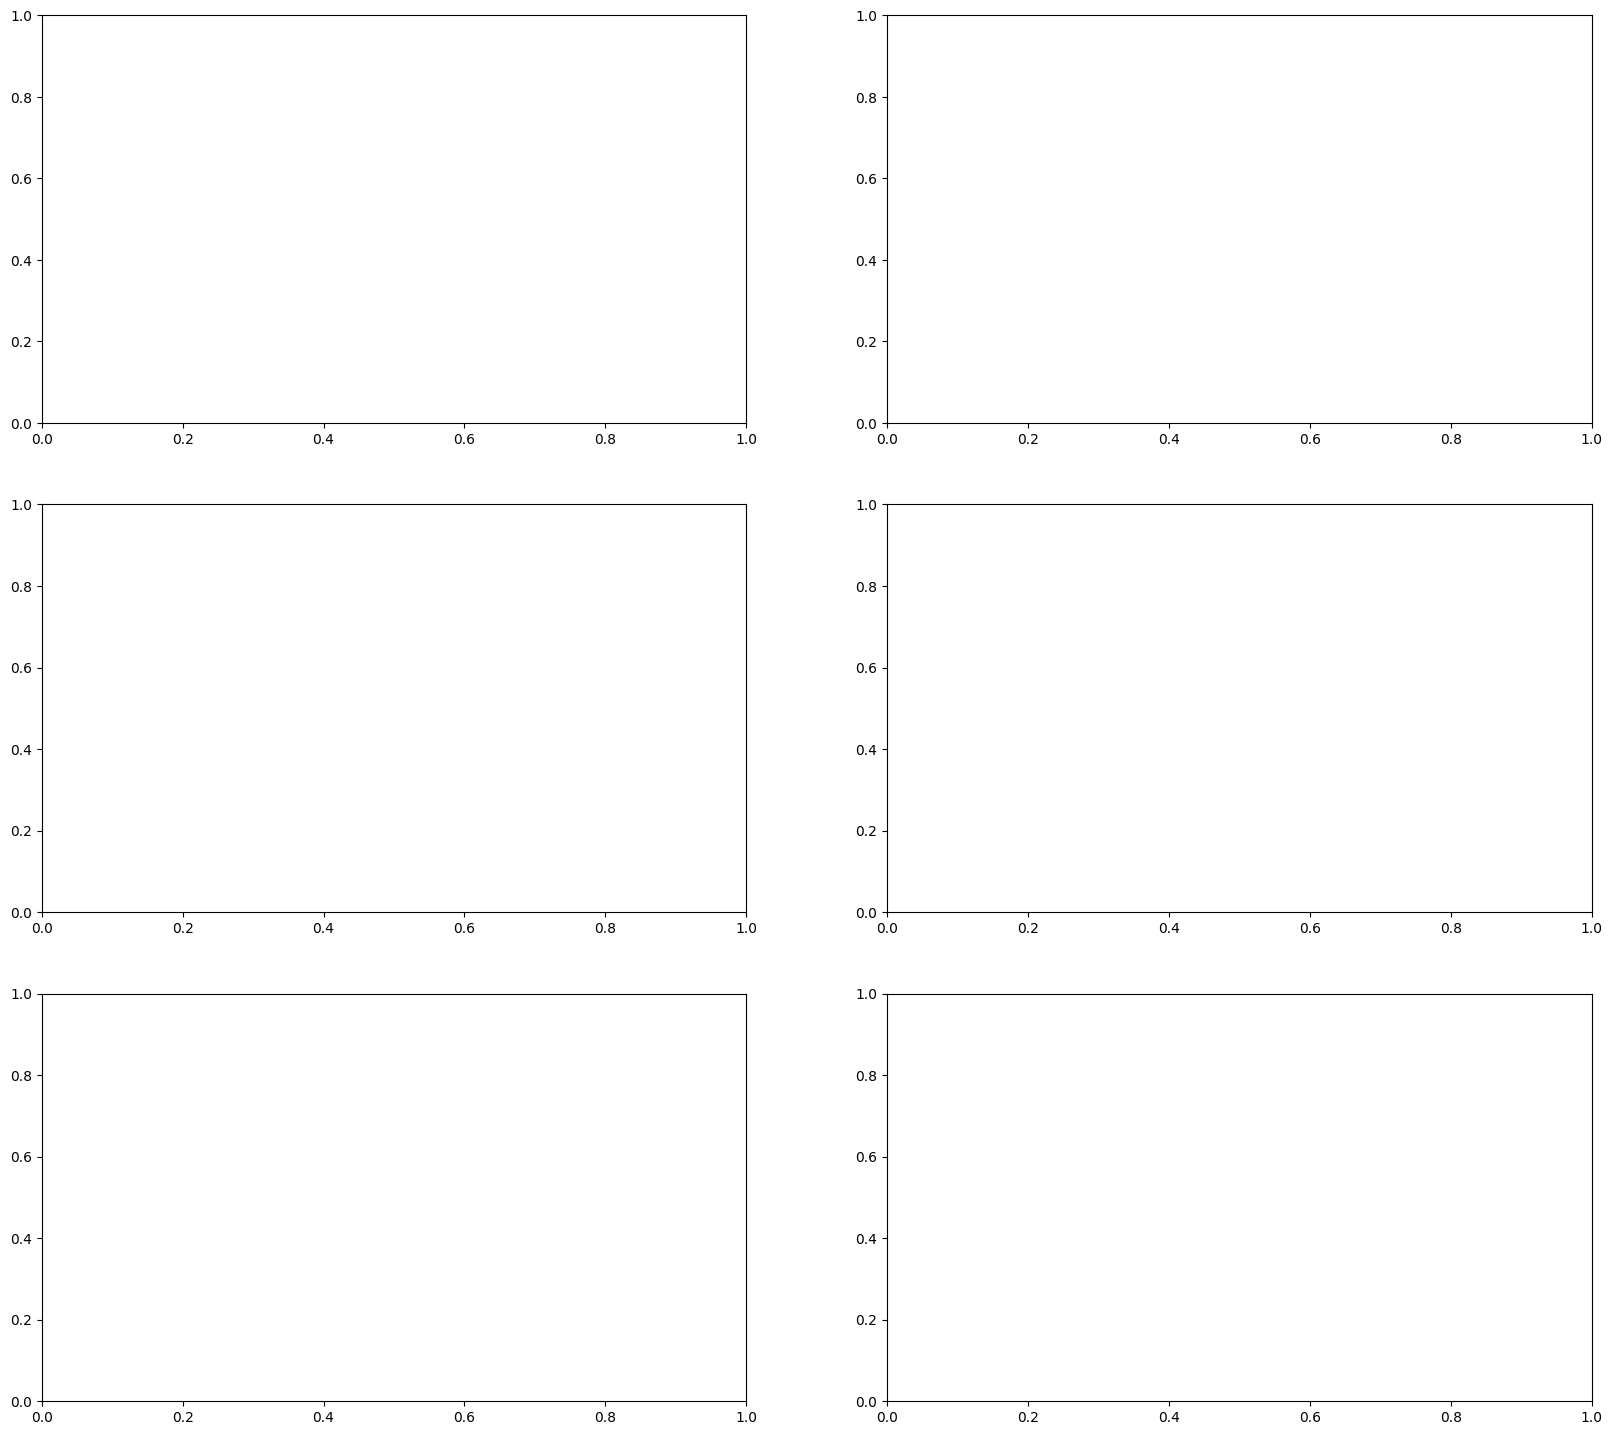

In [5]:
import matplotlib.pyplot as plt

# 손실 및 성능 지표 시각화
epochs = range(1, num_epochs + 1)

fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# Plot Training and Testing Loss
axes[0, 0].plot(epochs, train_history['loss'], label='Training Loss')
axes[0, 0].plot(epochs, test_history['loss'], label='Testing Loss')
axes[0, 0].set_xlabel('Epochs', fontsize=30)
axes[0, 0].set_ylabel('Loss', fontsize=30)
axes[0, 0].legend(fontsize=20)
axes[0, 0].set_title('Training and Testing Loss', fontsize=30)

# Plot Training and Testing Accuracy
axes[0, 1].plot(epochs, train_history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(epochs, test_history['accuracy'], label='Testing Accuracy')
axes[0, 1].set_xlabel('Epochs', fontsize=30)
axes[0, 1].set_ylabel('Accuracy', fontsize=30)
axes[0, 1].legend(fontsize=20)
axes[0, 1].set_title('Training and Testing Accuracy', fontsize=30)

# Plot Training and Testing Precision
axes[1, 0].plot(epochs, train_history['precision'], label='Training Precision')
axes[1, 0].plot(epochs, test_history['precision'], label='Testing Precision')
axes[1, 0].set_xlabel('Epochs', fontsize=30)
axes[1, 0].set_ylabel('Precision', fontsize=30)
axes[1, 0].legend(fontsize=20)
axes[1, 0].set_title('Training and Testing Precision', fontsize=30)

# Plot Training and Testing Recall
axes[1, 1].plot(epochs, train_history['recall'], label='Training Recall')
axes[1, 1].plot(epochs, test_history['recall'], label='Testing Recall')
axes[1, 1].set_xlabel('Epochs', fontsize=30)
axes[1, 1].set_ylabel('Recall', fontsize=30)
axes[1, 1].legend(fontsize=20)
axes[1, 1].set_title('Training and Testing Recall', fontsize=30)

# Plot Training and Testing F1
axes[2, 0].plot(epochs, train_history['f1'], label='Training F1 Score')
axes[2, 0].plot(epochs, test_history['f1'], label='Testing F1 Score')
axes[2, 0].set_xlabel('Epochs', fontsize=30)
axes[2, 0].set_ylabel('F1 Score', fontsize=30)
axes[2, 0].legend(fontsize=20)
axes[2, 0].set_title('Training and Testing F1 Score', fontsize=30)

# Plot Training and Testing ROC-AUC
axes[2, 1].plot(epochs, train_history['roc_auc'], label='Training ROC-AUC')
axes[2, 1].plot(epochs, test_history['roc_auc'], label='Testing ROC-AUC')
axes[2, 1].set_xlabel('Epochs', fontsize=30)
axes[2, 1].set_ylabel('ROC-AUC', fontsize=30)
axes[2, 1].legend(fontsize=20)
axes[2, 1].set_title('Training and Testing ROC-AUC', fontsize=30)

plt.tight_layout()
plt.show()


In [ ]:
token_ids